In [49]:
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import numpy as np
import pandas as pd
import re


In [50]:
# Read the data
df_comments1 = pd.read_pickle('./pickle_dataframes/comments1.pkl')
df_comments2 = pd.read_pickle('./pickle_dataframes/comments2.pkl')
df_comments = pd.concat([df_comments1,df_comments2])
df_comments.reset_index(drop=True, inplace=True)

df_posts1 = pd.read_pickle('./pickle_dataframes/posts1.pkl')
df_posts2 = pd.read_pickle('./pickle_dataframes/posts2.pkl')
df_posts3 = pd.read_pickle('./pickle_dataframes/posts3.pkl')
df_posts = pd.concat([df_posts1, df_posts2, df_posts3])
df_posts.reset_index(drop=True, inplace=True)

df_postlinks = pd.read_pickle('./pickle_dataframes/posts_links.pkl')
df_tags = pd.read_pickle('./pickle_dataframes/tags.pkl')
df_users = pd.read_pickle('./pickle_dataframes/users.pkl')

### Take a look at our DFs

In [51]:
df_comments.head()

,Id,PostId,Score,Text,CreationDate,UserId
0,1,1,9,Is it fair to inquire about the disadvantages ...,2012-12-04 22:00:00.933,28
1,3,1,3,"I could have reformulated the question, but at...",2012-12-04 22:02:37.737,18
2,7,2,2,Source on this? I don't see how it could possi...,2012-12-04 22:10:10.070,45
3,13,2,1,@Nick122 In a parliamentary system like the No...,2012-12-04 22:14:33.463,43
4,15,2,0,"Yes, but you will give a negative vote by voti...",2012-12-04 22:16:29.437,45


In [52]:
df_posts.head()

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount
0,1,1,-1,5,2012-12-04 21:40:29.743,42,8309,<p>We all know the situation could arise in th...,18,2019-06-29 09:18:38.430,What are the disadvantages of first-past-the-p...,<election><voting-systems><first-past-the-post>,3,3
1,2,1,-1,19,2012-12-04 21:53:18.800,26,7832,<p>I've heard that mathematically it can be sh...,21,2017-05-03 13:53:26.063,Why can't voting be fair if there are more tha...,<voting><political-theory><voting-systems>,4,3
2,4,2,1,-1,2012-12-04 21:58:11.187,7,-1,<p>First-past-the-post voting tends to result ...,26,2012-12-04 21:58:11.187,Comment: N/A,Comment: N/A,-1,1
3,5,2,1,-1,2012-12-04 21:58:39.037,47,-1,<p>Simple plurality voting has very little in ...,8,2012-12-04 22:04:42.767,Comment: N/A,Comment: N/A,-1,1
4,6,1,-1,28,2012-12-04 21:58:47.500,46,68096,<p>Living in a country where mandatory voting ...,18,2019-02-03 17:38:05.237,What are the advantages/disadvantages of a man...,<voting><voting-systems>,8,5


### Filtering Posts

In [53]:
questions_df = df_posts[df_posts['PostTypeId'] == 1]
questions_df_sample = questions_df.sample(frac=0.25)

### Text preprocessing

In [54]:
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords and Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)

In [55]:
# Apply the cleaning function to the Body and Title columns
questions_df_sample['Body_cleaned'] = questions_df_sample['Body'].apply(clean_text)
questions_df_sample['Title_cleaned'] = questions_df_sample['Title'].apply(clean_text)

In [ ]:
questions_df_sample.head()

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,Body_cleaned,Title_cleaned
0,1,1,-1,5,2012-12-04 21:40:29.743,42,8309,<p>We all know the situation could arise in th...,18,2019-06-29 09:18:38.430,What are the disadvantages of first-past-the-p...,<election><voting-systems><first-past-the-post>,3,3,know situation could arise u one candidate win...,disadvantage first past post electoral system
1,2,1,-1,19,2012-12-04 21:53:18.800,26,7832,<p>I've heard that mathematically it can be sh...,21,2017-05-03 13:53:26.063,Why can't voting be fair if there are more tha...,<voting><political-theory><voting-systems>,4,3,heard mathematically shown given voting system...,voting fair two alternative
4,6,1,-1,28,2012-12-04 21:58:47.500,46,68096,<p>Living in a country where mandatory voting ...,18,2019-02-03 17:38:05.237,What are the advantages/disadvantages of a man...,<voting><voting-systems>,8,5,living country mandatory voting exists experie...,advantage disadvantage mandatory voting system
5,7,1,-1,13,2012-12-04 22:08:50.417,83,10880,<p>When discussing political issues and partie...,20,2023-04-06 18:42:43.350,"What is meant by the ""left"" and the ""right""?",<parties><terminology><policy>,9,7,discussing political issue party often hear me...,meant left right
6,9,1,-1,18,2012-12-04 22:10:18.670,14,213,<p>I've read that some elections have instant ...,44,2017-06-14 13:06:44.500,How do instant runoffs work?,<election><voting><voting-systems>,1,1,read election instant runoff work differ stand...,instant runoff work


In [ ]:
# TF-IDF Transformation
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(questions_df_sample['Body_cleaned'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)  # Change n_components to the number of topics you want
lda.fit(tfidf)

# Assign topics to each document
topic_results = lda.transform(tfidf)
questions_df_sample['Topic'] = topic_results.argmax(axis=1)


In [ ]:
questions_df_sample

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,Body_cleaned,Title_cleaned,Topic
23275,38639,1,-1,-26893,2019-02-11 01:34:37.283,5,195,"<p>In Indian parliament, the president cannot ...",25013,2019-02-11 18:24:28.613,Money bills cannot be sent back by president i...,<india><parliament>,1,0,indian parliament president cannot send money ...,money bill cannot sent back president india pa...,1
45877,73639,1,-1,-1,2022-06-14 20:54:49.440,33,8270,"<p>As reported in the news, for example <a hre...",42942,2022-06-17 22:17:24.710,What is the reason for the high US inflation r...,<united-states><economy><inflation>,7,21,reported news example guardian u current infla...,reason high u inflation rate 2022,4
2961,4711,1,-1,-1,2014-08-17 12:02:03.720,2,3358,<p>Do Japanese governments support fluoridatio...,270,2022-06-16 13:31:54.133,Do Japanese governments support fluoridation?,<policy><japan><water>,1,4,japanese government support fluoridation wikip...,japanese government support fluoridation,4
39063,63194,1,-1,-2338,2021-03-25 18:40:35.033,26,7010,<p>I recently read that China's constitution r...,6105,2021-03-30 00:07:40.117,"What is a ""democratic dictatorship"", and how i...",<democracy><china><socialism><dictatorship>,10,2,recently read china constitution refers social...,democratic dictatorship contradiction term,4
41506,68330,1,-1,-1,2021-08-19 19:11:35.693,2,137,"<p>During the Trump administration, how did fo...",38911,2021-08-25 08:32:11.150,"During the Trump administration, how did forei...",<united-states><european-union><donald-trump><...,0,6,trump administration foreign state rank engagi...,trump administration foreign state rank engagi...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34639,56348,1,-1,-1,2020-08-14 16:52:47.270,12,1334,"<p>I know this is a worst-case scenario, but t...",21536,2020-08-18 13:51:26.177,What happens if not all ballots cast by mail a...,<united-states><election><presidential-electio...,5,7,know worst case scenario fact three issue happ...,happens ballot cast mail arrive time counted n...,4
47478,75564,1,-1,-1,2022-09-19 03:33:53.007,1,89,"<p>According to <a href=""https://repository.la...",18373,2022-09-26 08:39:08.080,Does China (still) use non-public trade regula...,<china><wto><regulation>,1,1,according 2014 paper u law professor many wto ...,china still use non public trade regulation ne...,4
30269,48517,1,-1,-1,2019-12-08 23:44:25.333,1,93,<p>It appears that President Trump's executive...,7434,2023-01-10 22:31:16.650,Is there an index that compares the percentage...,<united-states><executive-order>,0,8,appears president trump executive order often ...,index compare percentage president executive o...,4
41524,68353,1,-1,-1,2021-08-20 12:45:39.680,2,96,<p>I don't see this being discussed much. <a h...,35902,2021-08-20 15:40:43.533,How large of a percentage of the Afghan popula...,<nato><afghanistan>,0,11,see discussed much according cia 26 afghan pop...,large percentage afghan population nato ansf a...,4


In [ ]:
# Viewing the topics

feature_names = tfidf_vectorizer.get_feature_names_out()

# Define a function to display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top 10 words in each topic
display_topics(lda, feature_names, 10)

Topic 0:
criterion navy check honourable provision northern needed eez island france
Topic 1:
nuclear warrant weapon car egypt energy authorized model hold canada
Topic 2:
china world russian russia change public war nation ukraine want
Topic 3:
removed christian department appropriate nationalism used troop coup impeached map
Topic 4:
republican district biden policy administration local party strike control note
Topic 5:
extent uk caput formal corruption spending parent academic list notice
Topic 6:
canada visit territory corporation china afd chinese kind indian veto
Topic 7:
genocide phone international behaviour aggression cuba meat accepted commission wanted
Topic 8:
district org wiki en high carolina fbi belgium crisis oil
Topic 9:
public employer proof alternative innovation art town penny insurance date
Topic 10:
data transfer trip check exit dc popularity publishes border quote
Topic 11:
income republican libertarian civil rhode wearing lord nuke mask airline
Topic 12:
hong k

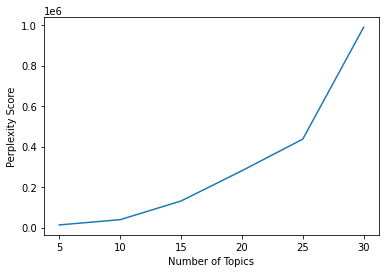

In [ ]:
# Perplexity is a statistical measure of how well a probability model predicts a sample. 
# In the context of LDA, lower perplexity might indicate a better model. 

# Example of calculating perplexity for different numbers of topics
n_topics = [5, 10, 15, 20, 25, 30]
perplexity_scores = []

for n in n_topics:
    lda = LatentDirichletAllocation(n_components=n, random_state=0)
    lda.fit(tfidf)
    perplexity_scores.append(lda.perplexity(tfidf))

# Plotting the perplexity scores
import matplotlib.pyplot as plt

plt.plot(n_topics, perplexity_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.show()